In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import math
import matplotlib.pyplot as plt

from pandas import get_dummies
from sklearn import preprocessing
from sklearn import cross_validation, metrics 
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score


%matplotlib inline
plt.style.use('ggplot')

In [2]:
from Bio.SeqUtils import ProtParamData  # Local
from Bio.SeqUtils import IsoelectricPoint  # Local
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.Data import IUPACData
from Bio.SeqUtils import molecular_weight
from Bio import SeqIO
from Bio.SeqUtils import ProtParam

## Feature engineering 
* Log50000
* chemical structure
* kidera factors
* Phylogenetic tree

In [3]:
"""
logarithming according to articles
"""
def log_meas(current):
    new_meas = 1 - math.log(current, 50000.0)
    if new_meas > 1: new_meas = 1
    if new_meas < 0: new_meas = 0
    return new_meas

In [4]:
"""
analyse_seq adds to DataFrame data with peptide sequences  columnns with chemical attributes of peptide
"""

def analyse_seq(sequences):
    physochem = pd.DataFrame()
    mol_weight = []
    aromaticity = []
    instability_index = []
    isoelectric_point = []
    for i in sequences:
        X = ProtParam.ProteinAnalysis(i)
        mol_weight.append(X.molecular_weight())
        aromaticity.append(X.aromaticity())
        instability_index.append(X.instability_index())
        isoelectric_point.append(X.isoelectric_point())
    physochem["molecular_weight"] = mol_weight
    physochem["aromaticity"] = aromaticity
    physochem["instability_index"] = instability_index
    physochem["isoelectric_point"] = isoelectric_point
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(physochem[["molecular_weight","instability_index", "isoelectric_point"]])
    x_scaled = pd.DataFrame(x_scaled, columns=["molecular_weight","instability_index", "isoelectric_point"])
    physochem["molecular_weight"] = pd.DataFrame(x_scaled["molecular_weight"])
    physochem["instability_index"] = pd.DataFrame(x_scaled["instability_index"])
    physochem["isoelectric_point"] = pd.DataFrame(x_scaled["isoelectric_point"])
    return physochem

In [5]:
"""
to_one_hot function replaces "sequence" row in DataFrame data with OneHotEncoded sequences
"""
def to_one_hot(data, length):
    NMers = data[data["peptide_length"] == length].reset_index(drop=True)
    letters = NMers.sequence.apply(list) 
    #data_1Hot = pd.get_dummies(pd.DataFrame(list(letters)))
    #return pd.concat([NMers.drop(["sequence"], axis = 1), data_1Hot], axis = 1)
    return pd.get_dummies(pd.DataFrame(list(letters)))
    

In [6]:
"""
select_by_allele function returns DataFrame, which consists from data for one mhc by its allele
"""
def select_by_allele(data, allele):
    return data[data.mhc == allele].drop(["mhc"], axis = 1).reset_index(drop = True)

In [7]:
"""
add_kidera_ftr function returns DataFrame with kidera factors on column for a given peptide
"""
def add_kidera_ftr(peptides):
    kidera_peptides = pd.DataFrame()
    for i,fact in enumerate(f): 
        kidera_peptides[fact]=[add_kidera(j)[i] for j in peptides]
        #kidera_selected[fact] = pd.DataFrame(data[fact][indexes]).reset_index(drop=True)
    return kidera_peptides

amino=pd.read_csv("acids.csv", sep=" ", index_col=False)
d = amino.to_dict(orient='list')
f = ['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10']

def add_kidera(pept):
    seq = list(pept)
    dim = len(seq)
    kidera = [0]*10
    for i in range(10):
        kidera[i] = [0]*dim
       
    for k in range(dim):
        for i in range(20):
            if seq[k] == d['amino'][i]:
                for j in range(10):
                    kidera[j][k] = d[f[j]][i]
   
    for i in range(10):
        kidera[i] = sum(kidera[i])/len(kidera[i])
   
    return kidera

## Dataset

In [8]:
Bdata = pd.read_csv("../mhc/bdata.csv")
Bdata.tail()
Bdata.meas = [log_meas(i) for i in Bdata.meas]

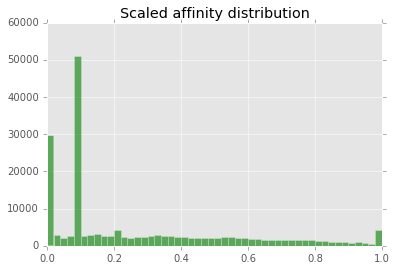

In [9]:
plt.title("Scaled affinity distribution")
hh = plt.hist(Bdata.meas, 50, color = 'green', alpha = 0.6)

## Sequence2Vector

In [10]:
# import modules & set up logging
import logging
import gensim
from gensim.models import word2vec
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
 

In [11]:
def fill_spaces(seq):
    new_seq = list(seq)
    for i in range(1, len(seq)):
        new_seq[i] = " "+ new_seq[i]
    return ''.join(new_seq)

def seq2vec(seq):
    return w2v_model[list(seq)].flatten()

In [12]:
sequences = Bdata.sequence.apply(fill_spaces)

In [13]:
min_word_count = 10   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 4          # Context window size                                                                                    
downsampling = 1e-3 
w2v_dim = 20

print("Training model...")
w2v_model = word2vec.Word2Vec(sequences, workers=num_workers, size = w2v_dim,
                              min_count = min_word_count, window = context, sample = downsampling)
print("Done.")

Training model...
Done.


In [14]:
def get_knn_feature(data, target):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-14-5dcf61a39ef3>, line 2)

## Dataframes with 9mers peptides

#### 1. Sequence embedding

In [15]:
seq2vec9mers = pd.DataFrame(Bdata[Bdata.peptide_length == 9].sequence.apply(seq2vec)).reset_index(drop=True)
seq2vec9mers = pd.DataFrame(list(seq2vec9mers.sequence))
seq2vec9mers.tail()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
129808,0.507427,-0.063755,0.026520,-0.088073,-0.067580,0.094896,-0.270169,0.267479,-0.093919,0.002721,...,0.181969,0.086413,0.247481,0.470953,-0.104824,-0.671785,-0.358374,-0.242323,0.403341,0.262397
129809,0.481050,-0.175727,0.147483,0.134723,0.011410,0.120494,-0.689428,-0.066464,-0.257794,0.077507,...,0.019496,0.003834,0.056211,0.336151,-0.775444,-0.880351,-0.164521,-0.289368,0.376510,0.567605
129810,0.529565,-0.029788,-0.105100,-0.372880,0.044189,0.157362,0.126351,-0.156275,-0.049245,-0.127461,...,0.026548,0.241312,-0.156993,0.234121,-0.197408,-0.547292,-0.091105,-0.341116,0.662170,0.756669
129811,0.693908,-0.095274,0.163296,0.065055,0.020704,0.395068,-0.189560,0.216262,-0.238161,-0.185653,...,-0.006650,-0.208704,0.042350,0.219471,-0.119690,-0.300209,-0.058304,0.046652,0.449859,0.613310
129812,0.794614,0.031035,0.317881,-0.199671,0.291524,-0.316058,-0.279619,0.378166,0.062694,0.016860,...,0.026548,0.241312,-0.156993,0.234121,-0.197408,-0.547292,-0.091105,-0.341116,0.662170,0.756669


#### 2.OneHotEncoding

In [16]:
OneHot9mers = to_one_hot(Bdata, 9)
OneHot9mers.tail()

,0_A,0_C,0_D,0_E,0_F,0_G,0_H,0_I,0_K,0_L,...,8_M,8_N,8_P,8_Q,8_R,8_S,8_T,8_V,8_W,8_Y
129808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129809,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
129810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129812,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 3. Physochemical properties

In [17]:
PhChemicalData = analyse_seq(Bdata[Bdata.peptide_length == 9].sequence)
PhChemicalData.tail()

,molecular_weight,aromaticity,instability_index,isoelectric_point
129808,0.372089,0.000000,0.280008,0.050803
129809,0.323164,0.111111,0.293921,0.064873
129810,0.528654,0.333333,0.353245,0.085869
129811,0.488379,0.111111,0.220120,0.050803
129812,0.533740,0.555556,0.264814,0.246062


#### 4.Kidera factors

In [18]:
KideraData = add_kidera_ftr(Bdata[Bdata.peptide_length == 9].sequence)
KideraData.tail()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10
129808,-0.011111,-0.355556,-0.186667,0.011111,-0.106667,-0.116667,-0.481111,-0.560000,-0.167778,-0.061111
129809,0.172222,-0.478889,-0.176667,-0.304444,0.096667,-0.404444,-0.238889,-0.028889,-0.250000,0.283333
129810,0.367778,0.122222,0.144444,0.002222,-0.051111,-0.146667,-0.062222,0.642222,0.040000,-0.567778
129811,-0.387778,-0.070000,-0.372222,0.003333,0.041111,0.073333,-0.040000,0.148889,-0.108889,0.062222
129812,-0.450000,0.132222,0.138889,-0.887778,-0.113333,-0.695556,0.007778,0.648889,0.823333,-0.368889


## Training XGboost

In [19]:
def affinity_to_classes(affinity):
    return pd.Series([round(10*i, 0) for i in affinity])

def affinity_to_binary(affinity):
    return pd.Series(map(lambda x: 1 if x >= 0.5 else 0, affinity))

In [43]:
def xgb_grid_search(data, target):
    
    # split
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.25, random_state=442)
    
    # train
    
    gbm_params = {
        'max_depth': [3, 7, 10],
        'n_estimators': [250, 350],
        'learning_rate': [0.2, 0.3],
        'max_delta_step': [5, 10]
    }
    
    print("GridSeachCV proceeding...")
    gbm = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic'), gbm_params, cv=5, verbose=10)
    gbm.fit(X_train, y_train)
    print("Done.")
    
    print(99*"="+ "\nBEST PARAMETERS: ", gbm.best_params_, "\n"+99*"="+"\n")
    predictions = gbm.predict(X_test, y_test)
    
    print("==================\ACCURACY : %.4g\n==================" % metrics.roc_auc_score(y_test, predictions))
    

In [21]:
affinity = Bdata[Bdata.peptide_length == 9].meas.reset_index(drop=True)
affinity_classes = affinity_to_classes(affinity)
affinity_binary = affinity_to_binary(affinity)

In [22]:
#xgb_grid_search(OneHot9mers, affinity_binary)

In [23]:
def xgb_best(data, target):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.25, random_state=442)
    
    gbm_best_params =  {'objective':'binary:logistic', 'learning_rate': 0.2, 'max_delta_step': 10, 'n_estimators': 250, 'max_depth': 7, 'cv':10, 'verbose':10}
    gbm = xgb.XGBClassifier(**gbm_best_params)
    
    gbm.fit(X_train, y_train)
    predictions = gbm.predict(X_test)
    print("Accuracy : %.4g" % metrics.roc_auc_score(y_test, predictions))
    
    

Best parameters:  {'learning_rate': 0.2, 'max_delta_step': 10, 'n_estimators': 250, 'max_depth': 7}

In [ ]:
data_many_features = pd.concat([KideraData, PhChemicalData, OneHot9mers], axis=1)
dataframes = [seq2vec9mers, KideraData, data_many_features]

for current_data in dataframes:
    xgb_grid_search(current_data, affinity_binary)